In [46]:
import os
import re
import time
import copy
import json
import random
import segyio
import pandas as pd
import numpy as np
import argparse
import math as m
import matplotlib.pyplot as plt

from typing import Tuple
from random import randrange
from omegaconf import OmegaConf
from hydra import compose, initialize
from conf.config import Configuration
from hydra.core.config_store import ConfigStore

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf

#import source.Params
#from source.Params import *
from source.pre_process import dataset_test_creator, standarlization, normalize_data
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from scipy.interpolate import interp1d
from segysak.segy import (
    segy_loader,
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
    well_known_byte_locs
)

os.environ["CUDA_VISIBLE_DEVICES"]="0"


gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
cs = ConfigStore.instance()
cs.store(name='execution_config', node=Configuration)

initialize(config_path="conf")
cfg = compose(config_name="config.yaml")

print(OmegaConf.to_yaml(cfg))

cfg.model_config.batch_size = 200

/tmp/ipykernel_16761/425108397.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="conf")


roi_config:
  roi_size: 200
  n_spacing_pixels_roi: 30
  roi_separation_in_percentage: 0.3
  n_traces_block: 1
  random_displacement: true
model_config:
  n_epochs: 150
  n_units_lstm_layers:
  - 256
  - 128
  - 64
  n_filters_dcunet: 64
  learning_rate: 0.0001
  batch_size: 1000
  SHUFFLE_BUFFER_SIZE: 1000
  concatenate_train_val_sequences: true
  validation_split_proportion: 0.35
  augmentation: true
  cross_validation_folds: null
regularexpression:
  expr_regular_match_filenames_2d: (([0-9]{4}\-[0-9]{4})(_ANP|ANP|_Ext|Ext|_E|E|_A|A|_CPGEO|CPGEO|(_{1}[0-9]+)*)?)
  expr_regular_match_filenames_3d_sgy: ([0-9A-Za-z_]+)(.sgy)
  expr_regular_match_filenames_3d_json: ([0-9A-Za-z_]+)-([A-za-z_]+).json
gas_config:
  n_spacing_pixels_gas: 10
seed_config:
  SEED: 123
file_path_config:
  base_dir: ''
  train_json: ''
  campos_base_dir: null
output_paths:
  tensorboard: Teste_Locations_BL102
  out_directory: Teste_Locations_BL102



/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [3]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[255] = [0., 0., 1., 1.]
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='filter',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [1., 0., 0., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='label',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [0., 1., 0., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='cpixel',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [0., 0., 1., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='cblue',colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

/tmp/ipykernel_16761/4210114844.py:12: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_16761/4210114844.py:19: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_16761/4210114844.py:26: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_16761/4210114844.py:32: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.reg

In [4]:
cfg.model_config.batch_size = 200
cfg.roi_config.roi_separation_in_percentage = 0.3
cfg.roi_config.n_spacing_pixels_roi = 25
cfg.roi_config.roi_size = 250

dataset = ['gvp', 'gvca', 'gvbl', 'dataset_treino_gvp_gvte_teste_gvp_gvb', 'lago_rodrigues']
dataset_name = dataset[4]

In [44]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def fix_gaps(list_traces, segy):
    # columns_insert = np.zeros((segy.shape[0]))
    traces_gap = []
    for i in range(len(list_traces)-1):

        if list_traces[i]+1 != list_traces[i+1]:
            print(list_traces[i+1], list_traces[i])
            traces_gap.append(list_traces[i+1] - list_traces[i])

            # for n_traces in range(n_traces_gap):
            #     segy = np.insert(segy, list_traces[i]+n_traces+1 - list_traces[0], columns_insert, axis=1)
    return traces_gap


def build_gt_from_json_points(path_seismic, seismic, gas_json):
    mask_subvolume = np.zeros(shape=seismic.shape)
    with segyio.open(path_seismic, "r") as segyfile:
        # Get inlines in cube
        start_inline = np.amin(segyfile.ilines)
        end_inline = np.amax(segyfile.ilines)
        # print('Similarity Inline range: ' + str(np.amin(segyfile.ilines)) + ' - ' + str(np.amax(segyfile.ilines)))

    # Create inline list
    inline_list = np.arange(start_inline, end_inline)

    gas_inlines = set([int(x) for x in gas_json.keys()]) & set(inline_list)

    # print(f'gas inlines in subvolume {gas_inlines}')
    line_thickness = src.Settings.params['n_Spacing_Pixels_Gas']

    for inlineNumber in gas_inlines:
        for point in gas_json[str(inlineNumber)]['gas_acumulation']:
            x = point[0]
            y = point[1]
            mask_subvolume[inlineNumber - start_inline, x, y: y + line_thickness] = 1.

    return mask_subvolume


def loadData2D(dict_seismics, dict_soleira, dict_gas, multiplas_roi=False):

    assert dict_seismics.keys() == dict_soleira.keys() == dict_gas.keys()

    dict_loaded_data = {}
    n_Spacing_Pixels_Gas = src.Settings.params['n_Spacing_Pixels_Gas']
    n_Spacing_Pixels_Soleira = src.Settings.params['n_Spacing_Pixels_Soleira']
    roi_size = src.Settings.params['roi_size']
    for line_number in dict_seismics:
        print(f'Carregando os dados da linha {line_number}')
        with segyio.open(dict_seismics[line_number], 'r', ignore_geometry=True) as f:  # 0 é o att. sismico
            sismica_original = f.trace.raw[:].T
            n_traces = f.tracecount
            trace_headers = parse_trace_headers(f, n_traces)

        # Checa para gaps na imagem sísmica e conserta adicionando colunas de zero quando necessário
        gaps_sismica = fix_gaps(list(trace_headers['TRACE_SEQUENCE_LINE']), sismica_original)

        (startRow, endRow) = dict_soleira[line_number]

        list_gas_points = dict_gas[line_number]


        mask = np.zeros(sismica_original.shape, dtype='uint8')

        #Transforma conjunto de pontos da acumulação de gás em uma imagem binária da posição da presença do gás.
        for gas_acc_points in list_gas_points:  # Para cada conjunto de pontos que forma uma acumulação de gás
            for point in gas_acc_points:  # Para cada ponto da imagem marcado como gás
                mask[point[1]: point[1] + n_Spacing_Pixels_Gas, point[0]] = 1

        if multiplas_roi:
            #Adiciona a roi com o tamanho de roi partindo do topo da soleira de cima
            key_roi1 = line_number + '_roi1'
            key_roi2 = line_number + '_roi2'
            top_cut_point_roi1 = startRow - n_Spacing_Pixels_Soleira
            top_cut_point_roi2 = (startRow - n_Spacing_Pixels_Soleira) - int(0.45 * roi_size)


            dict_loaded_data[key_roi1] = [ #Corte de acordo com as proporções definida para ROI-1
                #sismica_fix_gaps, #Sismica com adição dos traços nulos cortada como ROI
                sismica_original[top_cut_point_roi1: top_cut_point_roi1 + roi_size, :], #Sismica original cortada como ROI
                mask[top_cut_point_roi1: top_cut_point_roi1 + roi_size, :], #Mascara do gas de acordo com a ROI de traços nulos
                (top_cut_point_roi1, top_cut_point_roi1 + roi_size), #Ponto de corte da ROI original
                sismica_original,
                dict_seismics[line_number], #Nome da linha + ROI-1,
                gaps_sismica
            ]

            dict_loaded_data[key_roi2] = [ #Corte de acordo com as proporções definida para ROI-2
                #sismica_fix_gaps, #Sismica com adição dos traços nulos cortada como ROI
                sismica_original[top_cut_point_roi2: top_cut_point_roi2 + roi_size, :], #Sismica original cortada como ROI
                mask[top_cut_point_roi2: top_cut_point_roi2 + roi_size, :], #Mascara do gas de acordo com a ROI de traços nulos
                (top_cut_point_roi2, top_cut_point_roi2 + roi_size), #Ponto de corte da ROI original,
                sismica_original,
                dict_seismics[line_number], #Nome da linha + ROI-2,
                gaps_sismica
            ]

        else:
            dict_loaded_data[line_number] = [ #Corte de acordo com as proporções definida para ROI
                #sismica_fix_gaps[startRow - n_Spacing_Pixels_Soleira: endRow + n_Spacing_Pixels_Soleira + 1, :], #Sismica com adição dos traços nulos cortada como ROI
                sismica_original[startRow - n_Spacing_Pixels_Soleira: endRow + n_Spacing_Pixels_Soleira + 1, :], #Sismica original cortada como ROI
                mask[startRow - n_Spacing_Pixels_Soleira: endRow + n_Spacing_Pixels_Soleira + 1, :], #Mascara do gas de acordo com a ROI de traços nulos
                (startRow - n_Spacing_Pixels_Soleira, endRow + n_Spacing_Pixels_Soleira + 1),#Ponto de corte da ROI original
                sismica_original,
                dict_seismics[line_number], #Nome da linha,
                gaps_sismica
                                            ]

    return dict_loaded_data


        
def handle_2D_nogas(dict_soleira, 
                line_number, 
                trace_headers, 
                sismica, 
                dict_loaded_data, 
                dict_seismics, 
                multiplas_roi,
                mask):
    
    # Checa para gaps na imagem sísmica e conserta adicionando colunas de zero quando necessário
    # sismica = fix_gaps(list(trace_headers['TRACE_SEQUENCE_LINE']), sismica)
    n_Spacing_Pixels_Soleira = cfg.roi_config.n_spacing_pixels_roi
    roi_size = cfg.roi_config.roi_size

    sismica_fixgaps = fix_gaps(list(trace_headers['TRACE_SEQUENCE_LINE']), sismica)
    
    dict_loaded_data.fromkeys([line_number]) 
    dict_loaded_data[line_number] = dict_loaded_data.fromkeys(['2D'])

    startRow, endRow = dict_soleira
    sismica = normalize_data(sismica)
    if multiplas_roi:
        #Adiciona a roi com o tamanho de roi partindo do topo da soleira de cima
        key_roi1 = 'roi1'
        key_roi2 = 'roi2'
  
        top_cut_point_roi1 = int(startRow - n_Spacing_Pixels_Soleira)
        top_cut_point_roi2 = int((startRow - n_Spacing_Pixels_Soleira) - int(0.45 * roi_size))
        
        mask_roi1 = mask[top_cut_point_roi1: top_cut_point_roi1 + roi_size, :]
        mask_roi2 = mask[top_cut_point_roi2: top_cut_point_roi2 + roi_size, :]
        
        dict_loaded_data[line_number]['2D'] = dict_loaded_data.fromkeys([key_roi1, key_roi2])

        dict_loaded_data[line_number]['2D'][key_roi1] = [
            standarlization(sismica[top_cut_point_roi1: top_cut_point_roi1 + roi_size, :]),
            standarlization(sismica[top_cut_point_roi1: top_cut_point_roi1 + roi_size, :]),
            mask_roi1,
            (top_cut_point_roi1, top_cut_point_roi1 + roi_size),
            sismica,
            dict_seismics,
            sismica_fixgaps
                                     ]

        dict_loaded_data[line_number]['2D'][key_roi2] = [
            standarlization(sismica[top_cut_point_roi2: top_cut_point_roi2 + roi_size, :]),
            standarlization(sismica[top_cut_point_roi2: top_cut_point_roi2 + roi_size, :]),
            mask_roi2,
            (top_cut_point_roi2, top_cut_point_roi2 + roi_size),
            sismica,
            dict_seismics,
            sismica_fixgaps
                                     ]
    else:
        #Apenas uma ROI  
        mask = mask[startRow - n_Spacing_Pixels_Soleira: endRow + n_Spacing_Pixels_Soleira + 1, :]
            
        dict_loaded_data[line_number]['2D'] = [
            sismica,
            sismica[startRow - n_Spacing_Pixels_Soleira: endRow + n_Spacing_Pixels_Soleira + 1, :],
            mask,
            (startRow - n_Spacing_Pixels_Soleira, endRow + n_Spacing_Pixels_Soleira + 1),
            dict_seismics,
            
                                        ]
            
    return dict_loaded_data


def loadData2D_nogas(dict_seismics, dict_soleira):

    assert dict_seismics.keys() == dict_soleira.keys()

    dict_loaded_data = {}
    n_Spacing_Pixels_Soleira = cfg.roi_config.n_spacing_pixels_roi
    roi_size = cfg.roi_config.roi_size
    multiplas_roi = True
    
    for line_number in dict_seismics:
        print(f'Carregando os dados da linha {line_number}')
        with segyio.open(dict_seismics[line_number], 'r', ignore_geometry=True) as f:  # 0 é o att. sismico
            sismica_original = f.trace.raw[:].T
            n_traces = f.tracecount
            trace_headers = parse_trace_headers(f, n_traces)
            
        mask = np.zeros(sismica_original.shape, dtype='uint8')
        
        dict_loaded_data = handle_2D_nogas(dict_soleira[line_number], 
                                           line_number, 
                                           trace_headers, 
                                           sismica_original, 
                                           dict_loaded_data, 
                                           dict_seismics[line_number], 
                                           multiplas_roi,
                                           mask,
                                          )

    return dict_loaded_data


def datasets_loadGasPoints_2D(dir_gas):
    dict_gas = {}
    dict_gas.fromkeys(['LineNumber', 'gasPoints'])

    # Load gas and populate dictionary
    # gas_path = glob(str(dir_gas))
    for path_gas in dir_gas.keys():
    # for path_gas in gas_path:
        print(f'Loading gas from file {dir_gas[path_gas]}')
        with open(dir_gas[path_gas], 'r') as data_file:
            gas_json = json.load(data_file)

        list_gas_points = [] #Intended to be a list of list.
        for gas_accumulation_points in gas_json:
            list_single_gas_acumulation = gas_json[gas_accumulation_points]
            list_gas_points.append(list_single_gas_acumulation)

        m = re.search(src.Settings.params['expr_regular_match_filenames_2d'], dir_gas[path_gas]); assert m != None; # Test match
        lineNumber = m.group(0)
        dict_gas[lineNumber] = list_gas_points

    return dict_gas

def dataset_loadSoleiraPoints_2D(dict_soleira):
    # dict_soleira = {}
    # dict_soleira.fromkeys(['LineNumber', 'rowCutPoints'])
    #
    # # Load soleira and populate dictionary. Only entries that match lines on dict_gas.
    # soleiras_path = glob(str(dirSoleira))
    for path_sol in dict_soleira.keys():
    # for path_sol in soleiras_path:
        #m = re.search(src.Settings.params['expr_regular_match_filenames_2d'], dict_soleira[path_sol]); assert m != None # Test match
        m = re.search(expr_regular_match_filenames_2d, dict_soleira[path_sol])
        lineNumber = m.group(0)

        with open(dict_soleira[path_sol], 'r') as data_file:
            soleira_json = json.load(data_file)

        pointsTopSoleira = soleira_json['top_points']
        pointsBotSoleira = soleira_json['bot_points']
        ##Cut segy file by max and min point on rows
        top_points = np.array(pointsTopSoleira)[:, 1]
        bot_points = np.array(pointsBotSoleira)[:, 1]
        line_coordinates = np.concatenate((top_points, bot_points))  # all coordinates of lines(Y axis)

        # slice array from minimum point of column to maximum point on row
        startRow = min(line_coordinates)
        endRow = max(line_coordinates)

        # Insert new entry on dictionary
        dict_soleira[lineNumber] = (startRow, endRow)

    return dict_soleira


def dataset_loadSeismics_2D(dict_seismics_paths):
    dict_seismics = {}
    dict_seismics.fromkeys(['LineNumber', 'seismicPath'])

    # keys_soleira = set(list(dictSoleira.keys()))

    # seismics_path = glob(str(dir_seismics))
    for path_seism in dict_seismics_paths.keys():
    # for path_seism in seismics_path:
        #m = re.search(src.Settings.params['expr_regular_match_filenames_2d'], dict_seismics_paths[path_seism])
        m = re.search(expr_regular_match_filenames_2d, dict_seismics_paths[path_seism])
        assert m != None  # Test match
        lineNumber = m.group(0)
        dict_seismics[lineNumber] = dict_seismics_paths[path_seism]

    return dict_seismics


def copy_common_keys(d, keys):
    return {x: d[x] for x in d if x in keys}


def loadInputTest(dir_seismics, dir_soleira, dir_gas, mode):
    '''
    Load gas and soleira points into two dictionaries of the form (lineNumber, [points]).
    Use the id of lines from gas dictionary, to construct a seismics dictionary with the same line numbers with the form (lineNumber, pathSeismicFile).

    Those 3 dicts will be our base for the training dataset

    :param dir_seismics: Directory path containing segy files
    :param dir_soleira: Directory path containing soleira files in .json
    :param dir_gas: Directory path containing gas files in .json
    :return: 3 dictionaries with dataset informations
    '''

    if dir_gas == None:
        dict_soleira = dataset_loadSoleiraPoints_2D(dir_soleira)
        dict_seismics = dataset_loadSeismics_2D(dir_seismics)

        common_keys = list(set(dict_soleira.keys()) & set(dict_seismics.keys()))
        print(common_keys)

        dict_soleira = copy_common_keys(dict_soleira, common_keys)
        dict_seismics = copy_common_keys(dict_seismics, common_keys)

        assert sorted(dict_soleira.keys()) == sorted(dict_seismics.keys())

        return dict_seismics, dict_soleira
    else:
        dict_gas = datasets_loadGasPoints_2D(dir_gas)
        dict_soleira = dataset_loadSoleiraPoints_2D(dir_soleira)
        dict_seismics = dataset_loadSeismics_2D(dir_seismics)

        common_keys = list(set(dict_gas.keys()) & set(dict_soleira.keys()) & set(dict_seismics.keys()))
        print(common_keys)

        dict_gas = copy_common_keys(dict_gas, common_keys)
        dict_soleira = copy_common_keys(dict_soleira, common_keys)
        dict_seismics = copy_common_keys(dict_seismics, common_keys)

        assert sorted(dict_soleira.keys()) == sorted(dict_seismics.keys()) == sorted(dict_seismics.keys())

        return dict_seismics, dict_soleira, dict_gas

In [8]:
def check_seismic_acquisition_type(file):
    '''
    Return:
        ERROR: if file is not .sgy file or file appears corrupt
        3D: if file could be monted as 3D
        2D: if file could be opened as 2D
    '''

    try:
        segyio.cube(file)
        return '3D'
    except RuntimeError:
        # print(f"Erro ao abrir arquivo {file} como 3D" )

        try:
            with segyio.open(file, 'r', ignore_geometry=True) as f:
                n_traces = f.tracecount
                return '2D'
        except RuntimeError:
            # TO-DO: TEST WITH A CORRUPTED SGY FILE
            print("Erro ao abrir o arquivo {}".format(file))
            return 'ERROR'

def read_partition(basedir: str, partition: dict) -> Tuple[dict, dict]:
    dict_seismic = {}
    dict_soleira = {}
    dict_seismic.fromkeys(['LineNumber', 'Seismic'])
    dict_soleira.fromkeys(['LineNumber', 'Soleira'])

    for sample in partition["samples"]:  # For each seismic line sample in partition

        if not sample["errors"]:
            # print(sample["key"])
            key = sample['key']
            seismic = sample["properties"][0]['value']
            soleira = sample["properties"][1]['value']
            path_seismic = os.path.join(basedir, seismic)
            path_soleira = os.path.join(basedir, soleira)

            # debug
            print(key)
            print(path_seismic)
            print(path_soleira)
            print()

            # For each properties (Sgy, soleira) check if exists
            if not os.path.isfile(path_seismic):
                print("NOT FOUND {}".format(path_seismic))

            if not os.path.isfile(path_soleira):
                print("NOT FOUND {}".format(path_soleira))

            dict_seismic[key] = path_seismic
            dict_soleira[key] = path_soleira

    return dict_seismic, dict_soleira


def read_dataset_file(dataset_file: str, base_dir: str):
    with open(dataset_file, "r") as read_file:
        dataset = json.load(read_file)

    print("Dataset: ", dataset["name"])
    print("Dataset ID: ", dataset["id"])

    # Test if dataset has only one partition
    if len(dataset["partitions"]) != 1:
        Exception(ValueError('Incorrect dataset file. More then 1 partition.'))

    inference_partition = dataset["partitions"][0]

    print("Partition names:")
    print("{} Partition:".format(inference_partition["label"]))

    dict_seismic_inference, dict_soleira_inference = read_partition(base_dir, inference_partition)

    values_view = dict_seismic_inference.values()
    value_iterator = iter(values_view)
    first_sgy_path = next(value_iterator)

    mode = check_seismic_acquisition_type(first_sgy_path)

    return (dict_seismic_inference, dict_soleira_inference), mode


In [11]:
expr_regular_match_filenames_2d = r'(([0-9]{4}\-[0-9]{4})(_ANP|ANP|_Ext|Ext|_E|E|_A|A|_CPGEO|CPGEO|(_{1}[0-9]+)*)?)'
expr_regular_match_filenames_3d_sgy =  r'([0-9A-Za-z_]+)(.sgy)'
expr_regular_match_filenames_3d_json =  r'([0-9A-Za-z_]+)-([A-za-z_]+).json'

In [13]:
dataset_json = "json_files/lago_rodrigues.json"


((dict_seismic_inference, dict_soleira_inference), mode) = read_dataset_file(dataset_file=dataset_json, base_dir='')


seismics_inference, soleira_inference = loadInputTest(dict_seismic_inference,
                                                          dict_soleira_inference,
                                                          None, 
                                                          mode
                                                         )


Dataset:  Dataset Inferencia Lago dos Rodrigues
Dataset ID:  140
Partition names:
Amostras Partition:
0300-0001
../premioANP/2D/data/Lago_dos_Rodrigues/0300-0001_PSTM_2021_V1.sgy
../premioANP/2D/data/Lago_dos_Rodrigues/Horizons_RoI/0300-0001_RoI.json

0300-0002
../premioANP/2D/data/Lago_dos_Rodrigues/0300-0002_PSTM_2020_V1.sgy
../premioANP/2D/data/Lago_dos_Rodrigues/Horizons_RoI/0300-0002_RoI.json

0300-0003
../premioANP/2D/data/Lago_dos_Rodrigues/0300-0003_MigPre.sgy
../premioANP/2D/data/Lago_dos_Rodrigues/Horizons_RoI/0300-0003_RoI.json

0300-0004
../premioANP/2D/data/Lago_dos_Rodrigues/0300-0004_MigPre.sgy
../premioANP/2D/data/Lago_dos_Rodrigues/Horizons_RoI/0300-0004_RoI.json

0300-0017
../premioANP/2D/data/Lago_dos_Rodrigues/0300-0017_PSTM_2021_V1.sgy
../premioANP/2D/data/Lago_dos_Rodrigues/Horizons_RoI/0300-0017_RoI.json

0300-0018
../premioANP/2D/data/Lago_dos_Rodrigues/0300-0018_MigPre.sgy
../premioANP/2D/data/Lago_dos_Rodrigues/Horizons_RoI/0300-0018_RoI.json

0300-0020
../pre

In [47]:
inference_data = loadData2D_nogas(seismics_inference, soleira_inference)

Carregando os dados da linha 0300-0001
Carregando os dados da linha 0300-0002
Carregando os dados da linha 0300-0003
Carregando os dados da linha 0300-0004
Carregando os dados da linha 0300-0017
Carregando os dados da linha 0300-0018
Carregando os dados da linha 0300-0020
Carregando os dados da linha 0300-0021
Carregando os dados da linha 0300-0022
Carregando os dados da linha 0303-0024
Carregando os dados da linha 0303-0070
Carregando os dados da linha 0303-0080
Carregando os dados da linha 0303-0081
Carregando os dados da linha 0328-1101
Carregando os dados da linha 0328-1102
Carregando os dados da linha 0328-1103
Carregando os dados da linha 0328-1105
Carregando os dados da linha 0328-1106
Carregando os dados da linha 0328-1107
Carregando os dados da linha 0328-1109
Carregando os dados da linha 0328-1177
Carregando os dados da linha 0328-1179
Carregando os dados da linha 0328-1180
Carregando os dados da linha 0328-1184
Carregando os dados da linha 0375-1255
Carregando os dados da li

In [27]:
inference_data.keys()

dict_keys(['0300-0001', '0300-0002', '0300-0003', '0300-0004', '0300-0017', '0300-0018', '0300-0020', '0300-0021', '0300-0022', '0303-0024', '0303-0070', '0303-0080', '0303-0081', '0328-1101', '0328-1102', '0328-1103', '0328-1105', '0328-1106', '0328-1107', '0328-1109', '0328-1177', '0328-1179', '0328-1180', '0328-1184', '0375-1255', '0375-1256', '0375-1257', '0375-1258', '0375-1260', '0375-1261', '0375-1262', '0375-1263', '0375-1264', '0375-1299', '0375-1300', '0375-1301', '0375-1302', '0375-1303'])

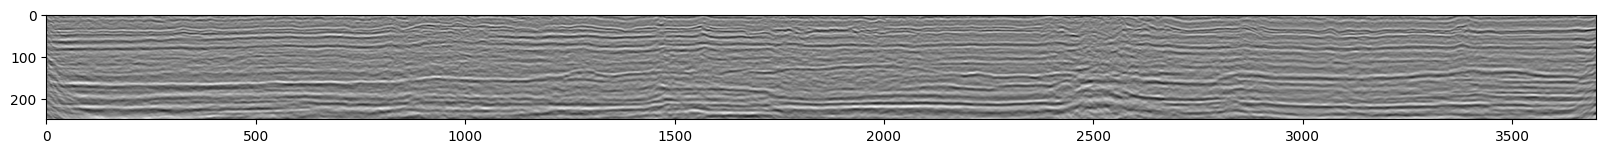

In [28]:
plt.figure(figsize = (20,20))
plt.imshow(inference_data['0300-0001']['2D']['roi2'][0], cmap='gray')
plt.show()

In [48]:
inference_data['0300-0001']['2D']['roi2'][0].std()

1.0000001

In [30]:


#for i in range(len(attrListTest)):
#    attrListTest[i] = standarlization(attrListTest[i])

In [41]:
import os
import json
import tqdm
import time
import math
import segyio
import shutil
import pathlib
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from conf.config import Configuration

from typing import Tuple, List, Union, Generic
from mpl_toolkits.axes_grid1 import make_axes_locatable

from source.metrics import Metrics
import source.Utils as Utils

from hydra.utils import get_original_cwd
log = logging.getLogger(__name__)




def date_str():
    now = time.localtime()
    return '{:02}_{:02}___{:02}_{:02}'.format(now.tm_mday, now.tm_mon, now.tm_hour, now.tm_min)


class Testing2DGPT():
    def __init__(self, 
                 test_data, 
                 model, 
                 save_dir, 
                 cfg,
                 batchsize=200):
        #super().__init__(test_data, model, save_dir, cfg)
        self.metrics_per_sample = []
        self.save_geolocation=False
        self.loaded_model = model
        self.batch_size = batchsize
        self.seismic_keys = []
        self.test_data = test_data
        self.cfg = cfg
        
        for key in test_data[0].keys():
            self.seismic_keys.append(key)
        
        



    #def init(self):
    #    Utils.register_colormap()
    
    def dataset_test_creator2D(self,
                               attribute_list, 
                               ID, 
                               roi_key
                              ):
        
        attributeList = [attr[ID]['2D'][roi_key][0] for attr in attribute_list]
        traceList = np.array(list(map(lambda attr: [np.expand_dims(attr[:, idx], axis=1) for idx in range(attr.shape[1])], attributeList)))
        x = np.concatenate(traceList, axis=2)
        
        return np.array(x)


    def load_well_locations(self):
        # Load well location positions
        with open(self.well_positions_file, encoding='utf-8') as file:
            self.well_locations = json.load(file)
            
    def predict(self, x):
        
        extra_traces = x.shape[0] % self.batch_size
        print(x.shape)
        y_pred_roi_ = self.loaded_model.forward_encoder(x[:extra_traces])
        y_pred_roi_ = self.loaded_model.forward_decoder(y_pred_roi_)
        y_pred_roi = np.argmax(y_pred_roi_, axis=-1)

        for i in range(extra_traces, len(x), self.batch_size):

            #y_pred_roi_ = self.loaded_model.predict(x[i:(i + self.batch_size)])
            y_pred_roi_ = self.loaded_model.forward_encoder(x[i:(i + self.batch_size)])
            y_pred_roi_ = self.loaded_model.forward_decoder(y_pred_roi_)
            y_pred_roi_ = np.argmax(y_pred_roi_, axis=-1)
            y_pred_roi = np.concatenate((y_pred_roi, y_pred_roi_), axis=0)
         
        return y_pred_roi
               
    
    def inference(self):
        """
            Perform inference on RoI and save the results in PNG and SGY.
        """
        #self.init()

        #self.load_well_locations()

        #self.create_output_dirs()
        
        if not os.path.exists(self.cfg.output_paths.out_directory + '/ImagensTeste'):
            os.makedirs(self.cfg.output_paths.out_directory  + '/ImagensTeste')

        if not os.path.exists(self.cfg.output_paths.out_directory + '/Sgy_Inference'):
            os.makedirs(self.cfg.output_paths.out_directory  + '/Sgy_Inference')

        # Define limits to geolocation plot
        max_x = -math.inf
        max_y = -math.inf
        min_x = math.inf
        min_y = math.inf

        roi_size = self.cfg.roi_config.roi_size
        roi_separation_in_percentage = self.cfg.roi_config.roi_separation_in_percentage
            
        #for seismic_obj in tqdm.tqdm(self.test_data, desc='Evaluating test set...'):
            
        for i in range(len(self.seismic_keys)):

            ID = self.seismic_keys[i] 
            roi_keys = list(self.test_data[0][ID]['2D'].keys())
            
            segypath = self.test_data[0][ID]['2D'][roi_keys[0]][5]
        
            first_roi = self.test_data[0][ID]['2D'][roi_keys[0]]
            second_roi = self.test_data[0][ID]['2D'][roi_keys[1]]

            x_test_roi1 = first_roi[0].T  ## Real data
            y_test_roi1 = first_roi[2].T
            
            x_test_roi2 = second_roi[0].T ## Real data
            y_test_roi2 = second_roi[2].T
            

            roi1Attr = self.dataset_test_creator2D(self.test_data, 
                                              ID, 
                                              roi_keys[0])
            
            roi2Attr = self.dataset_test_creator2D(self.test_data, 
                                              ID, 
                                              roi_keys[1])
            
            
            # ROI1
            # Fix shapes
            x_test_roi1 = np.expand_dims(x_test_roi1, axis=2)
            y_test_roi1 = np.expand_dims(y_test_roi1, axis=2)
            
            # Predict
            y_pred_roi1 = self.predict(roi1Attr)
            #Retorna do shape de one hot
            # Transform to Binary
            y_test_roi1 = np.squeeze(y_test_roi1)
            y_pred_roi1 = np.squeeze(y_pred_roi1)
            y_pred_roi1[y_pred_roi1 >= 0.5] = 1.0
            y_pred_roi1[y_pred_roi1 < 0.5] = 0.0

            #ROI2
            # Fix shapes
            x_test_roi2 = np.expand_dims(x_test_roi2, axis=2)
            y_test_roi2 = np.expand_dims(y_test_roi2, axis=2)
            # Predict
            y_pred_roi2 = self.predict(roi2Attr)
            #Retorna do shape de one hot
            # Transform to Binary
            y_test_roi2 = np.squeeze(y_test_roi2)
            y_pred_roi2 = np.squeeze(y_pred_roi2)
            y_pred_roi2[y_pred_roi2 >= 0.5] = 1.0
            y_pred_roi2[y_pred_roi2 < 0.0] = 0.0

            # CONCATENA AS INFERENCIAS DA ROI E BINARIZA
            pad1 = np.zeros(shape=(y_pred_roi1.shape[0], int(cfg.roi_config.roi_size * 0.45)))
            inferencia_pad_roi1 = np.concatenate([pad1, y_pred_roi1], axis=1)
            inferencia_pad_roi2 = np.concatenate([y_pred_roi2, pad1], axis=1)
            y_test_roi1 = np.concatenate([pad1, y_test_roi1], axis=1)
            y_test_roi2 = np.concatenate([y_test_roi2, pad1], axis=1)
            combined_y_test = y_test_roi1.T + y_test_roi2.T
            combined_inference = inferencia_pad_roi1.T + inferencia_pad_roi2.T

            #Binariza a resposta real concatenada e a resposta inferida concatenada
            combined_y_test[combined_y_test < 1.0] = 0.0
            combined_y_test[combined_y_test >= 1.0] = 1.0
            combined_inference[combined_inference < 1.0] = 0.0
            combined_inference[combined_inference >= 1.0] = 1.0

            #PEGA O TOP CUT POINT DA ROI1 E O BOT CUT POINT DA ROI2
            cut_point_roi1 = first_roi[3]
            cut_point_roi2 = second_roi[3]            
            cut_points = (cut_point_roi2[0], cut_point_roi1[1])

            # #CORTA A IMAGEM ORIGINAL NAS POSIÇÕES CORRETAS
            original_seismic = first_roi[4]
            original_seismic_corte_rois = original_seismic[cut_points[0]:cut_points[1]]

            metrics_obj = self.metrics_estimation(combined_y_test, combined_inference)
            self.metrics_per_sample.append((ID, metrics_obj))
            log.info(f'\n {ID}:\n {metrics_obj.__str__()} \n ----------------------------------------')

            # # # # Debug
            # fig, axs = plt.subplots(7, 1)
            # axs[0].imshow(y_pred_roi1, cmap='gray')
            # axs[1].imshow(y_pred_roi2, cmap='gray')
            # axs[2].imshow(inferencia_pad_roi1.T, cmap='gray')
            # axs[3].imshow(inferencia_pad_roi2.T, cmap='gray')
            # axs[4].imshow(original_sesimic_corte_rois, cmap='gray')
            # axs[5].imshow(combined_inference.T, cmap='gray')
            # axs[6].imshow(combined_y_test.T, cmap='gray')
            # plt.show()

            self.save_png(seismic=original_seismic_corte_rois,
                          true=combined_y_test,
                          pred=combined_inference,
                          save_title=ID,
                          save_name=ID,
                          outdir=self.cfg.output_paths.out_directory)
            
            #self.save_png_atualizado(y_pred=combined_inference,
            #                         segypath=seismic_view2d.file_path,
            #                         cut_points=(cut_point_roi2[0], cut_point_roi1[1]),
            #                         top_horizon=roi_top_points,
            #                         bot_horizon=roi_bot_points,
            #                         gas_horizons= gas_horizons,
            #                         well_locations=self.well_locations,
            #                         post_processing=False,
            #                         cut_twt_point=600,
            #                         save_path=self.save_dir + '/ImagensTeste/' + str(seismic_view2d.id) + '_Inference.png')
            
            
            self.save_inference_sgy(y_pred=combined_inference,
                                    cut_points=cut_points,
                                    segypath=segypath,
                                    ID=ID,
                                    outdir=self.cfg.output_paths.out_directory + '/Sgy_Inference'
                                   )

            '''
            Plot elements for map view for each inference
            '''
            if self.save_geolocation:
                prediction_seismic_path = seismic_view2d.file_path
                # seismic_inference, trace_header = Utils.get_trace_headers_and_seismic_inference(path_seismic=prediction_seismic_path)

                cdp_x, cdp_y = Utils.split_cdp_xy(trace_header)
                l_top_points, l_bot_points = seismic_view2d.roi_horizons

                fig.add_trace(go.Scatter(x=cdp_x, y=cdp_y, mode='lines',
                                        name=str(seismic_view2d.id), line=dict(color='green')))

                try:
                    selected_traces = Utils.find_traces_gas(
                        seismic_inference_original_shape, l_top_points, window_of_check_size=2)

                    tuple_gas_points_x, tuple_gas_points_y = Utils.get_gas_points(
                        selected_traces, cdp_x, cdp_y)

                    if len(tuple_gas_points_x) > 0 and \
                            len(tuple_gas_points_y) > 0:
                        max_x, max_y, min_x, min_y = Utils.get_well_plot_limits(
                            tuple_gas_points_x, tuple_gas_points_y, max_x, max_y, min_x, min_y)

                    # Plot gas markers
                    fig.add_trace(go.Scatter(x=tuple_gas_points_x, y=tuple_gas_points_y, mode='markers', marker=dict(
                        size=3.), line=dict(color='red'), name=f"{seismic_view2d.id} Predicted Gas"))
                except:
                    print(f'Error {seismic_view2d.id}')
                    
        if self.save_geolocation:
            # Plot other map elements
            Utils.plot_geometries_from_files(self.path_poligonos, fig)

            Utils.plot_well(self.well_locations, fig, max_x, max_y, min_x, min_y)

            # Set visualization params
            fig.update_yaxes(
                scaleanchor="x",
                scaleratio=1,
            )

            fig.update_layout({
                "plot_bgcolor": "rgba(0, 0, 0, 0)",
                "paper_bgcolor": "rgba(0, 0, 0, 0)",
            })

            fig.write_html(self.save_dir + '/ImagensTeste/' + self.save_name_geolocation + '.html')

        return


    def metrics_estimation(self, gt, pred):
        """
            params:
            gt - Ground Truth in np.ndarray
            predict - Prediction in np.ndarray
        """
        metrics_obj = Metrics(gt, pred)
        return metrics_obj

    def save_png(self, seismic, true, pred, save_title, save_name, outdir):
        seismic = np.squeeze(seismic)
        true = np.squeeze(true)
        pred = np.squeeze(pred)

        # pred[pred < 0.5] = 0
        # pred[pred >= 0.5] = 1

        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.logical_and(pred == 1.0, true == 1.0)

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.logical_and(pred == 0.0, true == 0.0)

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.logical_and(pred == 1.0, true == 0.0)

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.logical_and(pred == 0.0, true == 1.0)

        result = np.zeros(shape=(pred.shape[0], pred.shape[1], 3))

        result[TP] = np.array([1, 0, 0])
        # result[TN] = np.array([0, 0, 0])
        result[FP] = np.array([0, 1, 0])
        result[FN] = np.array([1, 1, 0])

        patches = [mpatches.Patch(color=[1, 0, 0], label="Matching Indication (TP)"),
                   #            mpatches.Patch(color=[0, 0, 0], label="True Negative"),
                   mpatches.Patch(color=[0, 1, 0], label="Wrong Model Prediction (FP)"),
                   mpatches.Patch(color=[1, 1, 0], label="Geoscientist Indication (FN)")]

        # Fix shapes
        seismic = np.swapaxes(seismic, axis1=0, axis2=1)
        seismic = np.transpose(seismic, (1, 0))
        
        result = np.swapaxes(result, axis1=0, axis2=1)
        result = np.transpose(result, (1, 0, 2))   

        # plt.figure(figsize=(20, 5))
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.imshow(seismic, cmap='gray')
        ax.imshow(result, alpha=0.4)

        plt.title(save_title)

        ax.legend(handles=patches, bbox_to_anchor=(1.01, 0.5), loc='upper left', ncol=1, frameon=False)

        if not os.path.exists(outdir + '/ImagensTeste'):
            os.makedirs(outdir + '/ImagensTeste')

        if outdir is not None:
            plt.savefig(outdir + '/ImagensTeste/' + str(save_name) + '_visualizacao.png', bbox_inches='tight', dpi=200)

        plt.close()

        return

    def save_probability_maps(self, x_test_roi1, y_pred_roi1, x_test_roi2, y_pred_roi2, seismic_id):
        fig, ax = plt.subplots(2,1, figsize=(10, 12))
        ax[0].imshow(x_test_roi1, cmap='gray')
        ax[0].imshow(y_pred_roi1, alpha=0.5)
        ax[1].imshow(x_test_roi2, cmap='gray')
        ax[1].imshow(y_pred_roi2, alpha=0.5)
        # plt.show()
        plt.savefig(self.cfg.output_paths.out_directory + '/ImagensTeste/' + 'probs_' + seismic_id + '_visualizacao.png', bbox_inches='tight',
                    dpi=300)
        plt.close(fig)

    def save_metrics(self):

        ids = [line_id for line_id, _ in self.metrics_per_sample]
        precision_results = [metric_obj.precision for _, metric_obj in self.metrics_per_sample]
        recall_results = [metric_obj.recall for _, metric_obj in self.metrics_per_sample]
        f1_score_results = [metric_obj.f1_score for _, metric_obj in self.metrics_per_sample]
        iou_results = [metric_obj.iou for _, metric_obj in self.metrics_per_sample]

        list_of_tuples = list(zip(ids, precision_results, recall_results, f1_score_results, iou_results))

        df = pd.DataFrame(data=list_of_tuples,
                          columns=['Linhas Sismicas', 'Precision', 'Recall', 'F1-Score', 'IoU'])
        df.to_csv(self.cfg.output_paths.out_directory + '/Individual_Test_report.csv', index=False, float_format='%.5f')

        log.info(tabulate(df, headers='keys', tablefmt='psql'))

        stats_dataframe = df.describe()
        stats_dataframe.to_csv(self.cfg.output_paths.out_directory + '/Test_report.csv', float_format='%.5f')
        log.info(tabulate(stats_dataframe, headers='keys', tablefmt='psql'))

    def save_png_atualizado(self, y_pred, segypath, cut_points, top_horizon, bot_horizon, gas_horizons, well_locations, post_processing,
                        cut_twt_point, save_path):
        with segyio.open(segypath, "r", ignore_geometry=True) as segy:
            # Memory map file for faster reading (especially if file is big...)
            segy.mmap()
            # Get basic attributes
            n_traces = segy.tracecount
            sample_rate = segyio.tools.dt(segy) / 1000
            n_samples = segy.samples.size
            twt = segy.samples
            data = segy.trace.raw[:].T
            trace_headers = Utils.parse_trace_headers(segy, n_traces)

        data = Utils.fix_gaps(list(trace_headers['TRACE_SEQUENCE_LINE']), data)
        (time_samples, n_tracos) = data.shape

        # (top_cut_point_roi1, top_cut_point_roi1 + roi_size)
        top = np.zeros((n_tracos, cut_points[0]))
        bottom = np.zeros((n_tracos, time_samples - cut_points[1]))

        inference_data = np.concatenate([top, y_pred, bottom], axis=1).T  # inference with same dimensions

        assert inference_data.shape == data.shape

        # Find extent of plot and custom ticks
        list_traces = list(trace_headers['TRACE_SEQUENCE_LINE'])
        start_trace = trace_headers['TRACE_SEQUENCE_LINE'].iloc[0]
        end_trace = trace_headers['TRACE_SEQUENCE_LINE'].iloc[-1]

        # Adjust TWT by the delaying time
        DRT = trace_headers['DelayRecordingTime'].iloc[0]
        twt = [twt[i] - DRT for i in range(len(twt))]
        if cut_twt_point > 0:
            twt = twt[0:cut_twt_point]

        x_top, y_top = zip(*top_horizon)
        x_bot, y_bot = zip(*bot_horizon)
        x_top_cdp = [i + start_trace - 1 for i in x_top]
        y_top_time = [int(i * sample_rate) for i in y_top]

        x_bot_cdp = [i + start_trace - 1 for i in x_bot]
        y_bot_time = [int(i * sample_rate) for i in y_bot]


        start_twt = twt[0]
        end_twt = twt[-1]
        extent = [start_trace, end_trace, end_twt, start_twt]  # Define plot extent

        # Define region where to keep inference and discard others
        if post_processing:
            inference_data = Utils.post_processing_step(y_top, y_bot, inference_data)

        # Define ticks for each axis
        custom_x_ticks = np.arange(start_trace, end_trace, int((end_trace - start_trace)/10)) # 10 ticks
        custom_y_ticks = np.arange(start_twt, end_twt, 500)

        # Find line compass card
        cdp_x = [p / 100 for p in list(trace_headers['CDP_X'])]
        cdp_y = [p / 100 for p in list(trace_headers['CDP_Y'])]

        cdp_points = np.asarray(list(zip(cdp_x, cdp_y)))

        iline_direction = np.array([float(cdp_x[-1] - cdp_x[0]), float(cdp_y[-1] - cdp_y[0])])
        orig, dest = Utils.compass_card(iline_direction)

        # Define clip percentile of amplitudes. Just for plotting purposes
        clip_percentile = 99
        vm = np.percentile(data, clip_percentile)

        # Plot Seismic figure
        fig = plt.figure(figsize=(18, 8))
        ax = fig.add_subplot(1, 1, 1)
        if cut_twt_point:
            data = data[:cut_twt_point, ...]
        im = ax.imshow(data, cmap="gray_r", vmin=-vm, vmax=vm, aspect='auto', extent=extent)

        # Horizons Plot
        ax.plot(x_top_cdp, y_top_time, color='b', linewidth=1.2, label='RoI Top Horizon')
        ax.plot(x_bot_cdp, y_bot_time, color='b', linewidth=1.2, label='RoI Bot Horizon')

        for gas_point_list in gas_horizons:
            x_gas, y_gas = zip(*gas_point_list)
            x_gas = [i + start_trace - 1 for i in x_gas]
            y_gas = [int(i * sample_rate) for i in y_gas]
            ax.plot(x_gas, y_gas, color="r", linewidth=2.5, label='Gas')

        # Plot inference
        if cut_twt_point:
            inference_data = inference_data[:cut_twt_point, ...]
        ax.imshow(inference_data, cmap="cpixel", aspect='auto', extent=extent)

        # Plot well lines
        for i in well_locations:
            for well_name in well_locations[i].keys():
                well_point = [int(well_locations[i][well_name][k]) for k in range(len(well_locations[i][well_name]) - 1)]
                well_status = well_locations[i][well_name][-1]
                top_i, bot_i, top_e, bot_e = Utils.get_line_rect(p_ini=(cdp_x[0], cdp_y[0]), p_end=(cdp_x[-1], cdp_y[-1]),
                                                        range=1200)
                if Utils.check_if_well_is_close(bot_i, top_i, top_e, bot_e, well_point):
                    proj_point = Utils.get_relative_point(initial_point=(cdp_x[0], cdp_y[0]),
                                                    end_point=(cdp_x[-1], cdp_y[-1]),
                                                    well_point=well_point)
                    distances = np.linalg.norm(cdp_points - np.array(proj_point), axis=1)
                    min_index = np.argmin(distances)

                    if str(well_status) == 'gas':
                        color = 'r'
                    elif str(well_status) == 'water':
                        color = 'b'
                    else:
                        color = 'w'

                    ax.text(list_traces[min_index] - 35, start_twt + 80, str(well_name), fontsize=8, color=color,
                            weight='bold')

                    ax.axvline(x=list_traces[min_index], ymin=0.35, ymax=0.95, c=color)

        # Plot compass data
        plt.text(start_trace, start_twt - 10, orig, fontsize=14)
        plt.text(0.99 * end_trace, start_twt - 10, dest, fontsize=14)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax.set_xlabel('CDP number')
        ax.set_xticks(custom_x_ticks)
        ax.set_yticks(custom_y_ticks)

        ax.set_ylabel('TWT [ms]')
        ax.set_title(f'{os.path.basename(segypath)}')
        plt.savefig(save_path, dpi=400)
        # plt.show()
        plt.close()
        return

    def save_inference_sgy(self, y_pred, cut_points, segypath, ID, outdir):
        
        with segyio.open(segypath, "r", ignore_geometry=True) as segy:
            segy.mmap()
            seismic = segy.trace.raw[:].T

        (time_samples, n_traces) = seismic.shape

        #(top_cut_point_roi1, top_cut_point_roi1 + roi_size)
        top = np.zeros((n_traces, cut_points[0]))
        bottom = np.zeros((n_traces, time_samples - cut_points[1]))

        inference_sgy_result = np.concatenate([top, y_pred.T, bottom], axis=1).T

        if seismic.shape != inference_sgy_result.shape:
            print('PROBLEMA EM EXPORTAR A SISMICA COMO SGY. Dimensões não correspondentes')
            return

        output_file = outdir + 'INFERENCE_' + str(ID.split('_')[0]) + '.sgy'
        if not seismic.shape == inference_sgy_result.shape:
            raise AssertionError("Mismach shapes.")
        else:
            shutil.copyfile(segypath, output_file)
            inference_sgy_result = inference_sgy_result.astype('float32')
            with segyio.open(output_file, "r+", ignore_geometry=True) as dst:
                dst.trace.raw[:] = inference_sgy_result.T

In [38]:
def Encoder(embed_dim,
            num_heads,
            mlp_ratio,
            depth
           ):
    
    inputs = tf.keras.layers.Input((None, embed_dim))
    x = inputs
    for _ in range(depth):

        # Create a multi-head attention layer.  
        
        
        att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=(embed_dim // num_heads), dropout=0.1
        )(x, x)
        
        

        # Skip connection 1.
        skip = x + att
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skip)
        
        # Feed Forward Part
        x = tf.keras.layers.Dense(int(embed_dim*mlp_ratio), activation='gelu')(x)
        x = tf.keras.layers.Dense(embed_dim)(x)
        x = tf.keras.layers.Dropout(0.1)(x)

        # Skip connection 2.
        x = x + skip     
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        
        
    
    model = tf.keras.Model(inputs, x, name="encoder_block")
    
    return model


class AlineGPT(tf.keras.Model):

    
    def __init__(self, num_classes=2,
                 embed_dim=384, depth=3, num_heads=6,
                 mlp_ratio=4.,
                 dropout_rate=0.1,
                 batch_size=8):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = tf.keras.layers.Dense(embed_dim, activation='linear')

        
        model_enc =  Encoder(embed_dim,
                                num_heads,
                                mlp_ratio,
                                depth
                               )
        
        #model_enc.built = True 
        #model_enc.load_weights('weights/checkpoint2024-03-0015-20-03/checkpoint_test_encoder.h5')
        
        self.encoder = model_enc
        
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # Decoder specifics
        self.proj_layer = tf.keras.layers.Dense(512, activation='softmax')
        
        self.lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))
        self.lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))
        self.lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
        self.dropout_1 = tf.keras.layers.Dropout(rate=0.2)
        self.dropout_2 = tf.keras.layers.Dropout(rate=0.2)
        self.dropout_3 = tf.keras.layers.Dropout(rate=0.2)

        
        self.output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
        
        # --------------------------------------------------------------------------

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")


    def forward_encoder(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)

        return x

    def forward_decoder(self, x):
        x = self.proj_layer(x)
        x = self.lstm_1(x)
        x = self.dropout_1(x)
        x = self.lstm_2(x)
        x = self.dropout_2(x)
        x = self.lstm_3(x)
        x = self.dropout_3(x)
        
        x = self.output_layer(x)

        return x
    
    def compile(self, optimizer, loss_fn):
            super().compile()
            self.optimizer = optimizer
            self.loss_fn = loss_fn
            
    def train_step(self, data):
        X, Y = data
        with tf.GradientTape() as tape:
            
            latent = self.forward_encoder(X)
            pred = self.forward_decoder(latent)  # [N, L, p*p*3]
            
            loss = self.loss_fn(Y,
                                pred)
            
    
            # Apply gradients.
        train_vars = [
            self.encoder.trainable_variables, ## comment this line in case of finetuning
            self.lstm_1.trainable_variables,
            self.lstm_2.trainable_variables,
            self.lstm_3.trainable_variables,
            self.dropout_1.trainable_variables,
            self.dropout_2.trainable_variables,
            self.dropout_3.trainable_variables,
            self.patch_embed.trainable_variables,
            self.output_layer.trainable_variables,
            self.proj_layer.trainable_variables,
        ]
        
        
        grads = tape.gradient(loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.        
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        X, Y = data
        latent = self.forward_encoder(X)
        pred = self.forward_decoder(latent)  # [N, L, p*p*3]
            
        loss = self.loss_fn(Y,
                            pred)
        
        
        self.loss_tracker.update_state(loss)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {"loss": self.loss_tracker.result()}

In [39]:
#model_checkpoint_name = '2D/GPT/dataset_treino_gvp_gvte_teste_gvp_gvb/checkpoint_ 2024-05-0009-08-23-00/model/WeightTrained-2024-05-0009-08-23-00.cpk'

modelBest = AlineGPT(num_classes=2,
                 embed_dim=192, 
                 depth=3,
                 mlp_ratio=4.,
                 num_heads=6
                )

modelBest.built = True
modelBest.load_weights(model_checkpoint_name)
modelBest.summary()

Model: "aline_gpt_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             multiple                  0 (unused)
                                                                 
 encoder_block (Functional)  (None, None, 192)         1334592   
                                                                 
 dense_16 (Dense)            multiple                  0 (unused)
                                                                 
 bidirectional (Bidirection  multiple                  0 (unused)
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  multiple                  0 (unused)
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  multiple                  

In [49]:
attrListTest = []
attrListTest.append(inference_data)

In [50]:
cfg.output_paths.out_directory = 'parnaiba_2D/AlineGPT/Lago_rodrigues_norm/'
if not os.path.exists(cfg.output_paths.out_directory):
    os.makedirs(cfg.output_paths.out_directory)



print('TEST METRICS')
testing = Testing2DGPT(
    test_data=attrListTest,
    model=modelBest,
    save_dir=cfg.output_paths.out_directory,
    cfg=cfg,
    batchsize=cfg.model_config.batch_size,
)
testing.inference()
testing.save_metrics()

TEST METRICS
(3701, 250, 1)
(3701, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3695, 250, 1)
(3695, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3691, 250, 1)
(3691, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3695, 250, 1)
(3695, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3683, 250, 1)
(3683, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3683, 250, 1)
(3683, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3700, 250, 1)
(3700, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3694, 250, 1)
(3694, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3693, 250, 1)
(3693, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(6057, 250, 1)
(6057, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3313, 250, 1)
(3313, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(5607, 250, 1)
(5607, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(5817, 250, 1)
(5817, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(10376, 250, 1)
(10376, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(7672, 250, 1)
(7672, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(10161, 250, 1)
(10161, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4976, 250, 1)
(4976, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2821, 250, 1)
(2821, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(5169, 250, 1)
(5169, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2491, 250, 1)
(2491, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4671, 250, 1)
(4671, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4069, 250, 1)
(4069, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(3462, 250, 1)
(3462, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4591, 250, 1)
(4591, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1929, 250, 1)
(1929, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1961, 250, 1)
(1961, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1849, 250, 1)
(1849, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2189, 250, 1)
(2189, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(822, 250, 1)
(822, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1095, 250, 1)
(1095, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1961, 250, 1)
(1961, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1953, 250, 1)
(1953, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1313, 250, 1)
(1313, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1449, 250, 1)
(1449, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(642, 250, 1)
(642, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1313, 250, 1)
(1313, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1704, 250, 1)
(1704, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(1732, 250, 1)
(1732, 250, 1)


/local/lsantos/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
def direction(iline_direction: np.ndarray):
    """ Calculates the angle between the given vector and the referential vector (1.,0.).

    :param iline_direction: The two dimentional array which angle will be calculated.

    :return: Return de the angle between the vector(1.,0.) and iline_direction in degrees.
    """
    a = np.array([1., 0.])
    b = iline_direction
    sin_th1 = np.cross(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    cos_th1 = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    degree = np.rad2deg(np.arctan2(sin_th1, cos_th1))

    if degree < 0:
        degree += 360

    return degree


def compass_card(iline_direction: np.ndarray):
    """ Gives the closest cardinal direction to which a vector is pointing.

    :param iline_direction: The two dimentional array which cardinal direction will be returned.

    :return: A Tuple of str which are the origin of the closest cardinal direction and where it is pointed.
    """
    degree = direction(iline_direction)

    e = 0.
    e_2 = 360
    w = 180.
    n = 90.
    s = 270.

    ne = (n + e) / 2
    nw = (n + w) / 2
    se = (s + e_2) / 2
    sw = (s + w) / 2

    CC = [e, ne, n, nw, w, sw, s, se]
    CC_names = ['E', 'NE', 'N', 'NW',
                'W', 'SW', 'S', 'SE']
    min_degree = 360
    min_pos = -1
    for i, cc in enumerate(CC):
        dist_degree = abs(cc - degree)
        if min_degree > dist_degree:
            min_degree = dist_degree
            min_pos = i

    if (e_2 - degree) < min_degree:  # case for fourth quadrant near E
        min_pos = 0

    return CC_names[(min_pos + 4) % 8], CC_names[min_pos]



def plot_2D_visualization(segy_cube, inference_cube, output_path: str,
                          slice_beg: int, slice_end: int, gas: Union[str, dict] = ''):
    """ Saves the plot for 2D visualizations.

    :param segy_cube: The opened segy file cube with the seismic data.
    :param inference_cube: The opened segy file cube with the inference data.
    :param output_path: The path that the file will be saved.
    :param slice_beg: The beginning of the range of the time slice which the plot will be made.
    :param slice_end: The end of the range of the time slice which the plot will be made.
    :param roi: The .json file or dictionary containing the roi data.
    :param gas: The .json file or dictionary containing the gas data.
    """

    if isinstance(gas, str):
        if gas == '':
            gas_data = {}

        else:
            with open(gas, 'r') as f:
                gas_data = json.load(f)
    elif isinstance(gas, dict):
        gas_data = gas

    fig, ax = plt.subplots(ncols=1, figsize=(12, 4), dpi=200, sharey=True, constrained_layout=True)

    #crosslineX = segy_cube['cdp_x']
    #crosslineY = segy_cube['cdp_y']

    #iline_direction = np.array([float(crosslineX[-1] - crosslineX[0]), float(crosslineY[-1] - crosslineY[0])])

    #orig, dest = compass_card(iline_direction)

    if slice_beg == -1 or slice_end == -1:
        colorbar = plt.colorbar(segy_cube.data.transpose("twt", "cdp", transpose_coords=True
                                                         ).plot(yincrease=False, cmap="Greys", add_colorbar=False))

        if inference_cube is not None:
            colorbar2 = plt.colorbar(inference_cube.data.transpose("twt", "cdp", transpose_coords=True
                                                                   ).plot(yincrease=False, cmap="cpixel",
                                                                          add_colorbar=False))

    else:
        colorbar = plt.colorbar(segy_cube.data.transpose("twt", "cdp", transpose_coords=True).sel(
            twt=slice(slice_beg, slice_end)
        ).plot(yincrease=False, cmap="Greys", add_colorbar=False), anchor=(1.5, 0))

        if inference_cube is not None:
            colorbar2 = plt.colorbar(inference_cube.data.transpose("twt", "cdp", transpose_coords=True).sel(
                twt=slice(slice_beg, slice_end)
            ).plot(yincrease=False, cmap="cpixel", add_colorbar=False))

    colorbar.set_label("Amplitude")
    if inference_cube is not None:
        colorbar2.remove()

    plt.ylabel("TWT (ms)")
    plt.xlabel("XLINE")

    if gas_data != {}:

        for key in gas_data.keys():
            x_gas = [x for x, _ in gas_data[key]]
            y_gas = [y*4 for _, y in gas_data[key]]
            ax.plot(x_gas, y_gas, color="r", linewidth=2, label='Gas')
            
    

    
    ax.plot(0, 0, color="lime", label="GPT Prediction")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=3)
    #plt.text(0, slice_beg - 10, orig, fontsize=14)
    #plt.text(int(0.97 * int(segy_cube['cdp'][-1])), slice_beg - 10, dest, fontsize=14)
    plt.title("Line " + segy_cube.attrs['source_file'][:-4])

    plt.savefig(output_path + segy_cube.attrs['source_file'][:-4] + '_visualization.png')



def plot_3D_visualization(segy_cube, inference_cube, output_path: str,
                          inlineNumber: int, slice_beg: int, slice_end: int,
                          roi: Union[str, dict], gas: Union[str, dict] = ''):
    """ Saves the plot for 2D visualizations.

    :param segy_cube: The opened segy file cube with the seismic data.
    :param inference_cube: The opened segy file cube with the inference data.
    :param output_path: The path that the file will be saved.
    :param inlineNumber: The inline that will be plotted.
    :param slice_beg: The beginning of the range of the time slice which the plot will be made.
    :param slice_end: The end of the range of the time slice which the plot will be made.
    :param roi: The .json file or dictionary containing the roi data.
    :param gas: The .json file or dictionary containing the gas data.

    """
    

    if isinstance(roi, str):
        if roi == '':
            roi_data = {}
        else:
            with open(roi, 'r') as f:
                roi_data = json.load(f)
    elif isinstance(roi, dict):
        roi_data = roi

    if isinstance(gas, str):
        if gas == '':
            gas_data = {}

        else:
            with open(gas, 'r') as f:
                gas_data = json.load(f)
    elif isinstance(gas, dict):
        gas_data = gas

    f, ax = plt.subplots(nrows=1, figsize=(12, 4), dpi=200, sharey=True, constrained_layout=True)
    inlineNumber = int(inlineNumber)
    for i in range(inlineNumber):
        if segy_cube['cdp_x'][i]['iline'] == inlineNumber:
            crosslineX = segy_cube['cdp_x'][i]
            crosslineY = segy_cube['cdp_y'][i]
            break

    iline_direction = np.array([float(crosslineX[-1] - crosslineX[0]), float(crosslineY[-1] - crosslineY[0])])

    orig, dest = compass_card(iline_direction)

    colorbar = plt.colorbar(segy_cube.data.transpose("twt", "iline", "xline", transpose_coords=True).sel(
        iline=inlineNumber,
        twt=slice(slice_beg, slice_end)
    ).plot(yincrease=False, cmap="Greys", add_colorbar=False))

    if inference_cube is not None:
        colorbar2 = plt.colorbar(inference_cube.data.transpose("twt", "iline", "xline", transpose_coords=True).sel(
            iline=inlineNumber,
            twt=slice(slice_beg, slice_end)
        ).plot(yincrease=False, cmap="cpixel", add_colorbar=False))

    colorbar.set_label("Amplitude")

    if inference_cube is not None:
        colorbar2.remove()
    xroitop = [x for x, y in roi_data['top_points'][str(inlineNumber)]]
    yroitop = [y for x, y in roi_data['top_points'][str(inlineNumber)]]

    xroibot = [x for x, y in roi_data['bot_points'][str(inlineNumber)]]
    yroibot = [y for x, y in roi_data['bot_points'][str(inlineNumber)]]

    if gas_data != {}:
        xgas = [x for x, y in gas_data[str(inlineNumber)]['gas_acumulation']]
        ygas = [y for x, y in gas_data[str(inlineNumber)]['gas_acumulation']]

        ax.plot(xgas, ygas, color="r", linewidth=2, label='Gas')
    #ax.plot(xroitop, yroitop, color="m", label='RoI')
    #ax.plot(xroibot, yroibot, color="m")
    ax.plot(0, 0, color="lime", label="GPT Prediction")
    ax.legend(loc="upper right")
    ax.set_title('Inline ' + str(inlineNumber))
    ax.set_xlabel("XLINE")
    ax.set_ylabel("TWT (ms)")
    #plt.text(0, slice_beg - 10, orig, fontsize=14)
    #plt.text(int(0.97 * int(xroibot[-1])), slice_beg - 10, dest, fontsize=14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=3)

    plt.savefig(output_path + 'Inline_' + str(inlineNumber) + '_visualization.png')

In [ ]:
outputdir = cfg.output_paths.out_directory + '/new_plot/'

for view in test_data:
    ID = view.id
    segy_path = view.file_path
    gas_json = view.gas_horizons
    segy_path2D_json = view.label_file_path
    
    line_2D = segy_loader(segy_path)
    shift = line_2D.twt[0]
    for i in range(len(line_2D.twt)):
        line_2D.twt.values[i] = line_2D.twt.values[i] - shift

    segy_infe_path2D = cfg.output_paths.out_directory + '/Sgy_Inference/' +  'INFERENCE_' + ID + '.sgy'
    cube_infe2D = segy_loader(segy_infe_path2D)
    shift = cube_infe2D.twt[0]
    
    for i in range(len(cube_infe2D.twt)): 
        cube_infe2D.twt.values[i] = cube_infe2D.twt.values[i] - shift
    
    plot_2D_visualization(line_2D, cube_infe2D, outputdir, 900, 1650, segy_path2D_json)